In [1]:
from __future__ import print_function
import os, time, random, glob
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from torchvision import transforms
# from tensorboardX import SummaryWriter

from MothScripts.dataset import ImageDatasetFromFile
from MothScripts.networks import DFC_VSC_WGAN
from MothScripts.resnet50_classifier import ResNet50_family_classifier
from MothScripts.average_meter import AverageMeter

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

# 檢查系統與軟體版本
print(pd.__version__)
print(np.__version__)
print(torch.__version__)
!python -V
# !jupyter --version
!jupyter notebook --version
!jupyter lab --version

1.0.3
1.18.1
1.4.0
Python 3.6.10
6.0.0
1.2.1


### 1. 量化影像特徵  
#### 1.1. 用 encoder 將鱗翅目影像編碼  
- 編碼為 output shape==[N, 512] 的 array of features, N==照片總數。  
- 建議可從較小的數字開始練習，減少試誤時間。因為 GPU 正在訓練 DFC-VSC，萬一空間不夠，可能要用 CPU 練習。  
- 把完整的 features 存起來方便以後 reuse。數量與順序要與 metadata (科、屬、種、照片檔名) 一致。

#### 1.2. 畫出每一維特徵
- 用 decoder 生成每一維從 min to 0 to max 的連續值代表的影像。內插值間距自訂。
- 由於 VSC 抽出的特徵值會非常集中在 0 的附近，在極值附近(min to Q05 跟 Q95 to max) 可考慮用較細的間距。
- 最後要得到 512 組圖，每一組代表一個特徵從 min to 0 to max 的變化。

In [2]:
# 函式庫

str_to_list = lambda x: [int(xi) for xi in x.split(',')]

def is_image_file(filename):
    return any(filename.lower().endswith(extension) for extension in [".jpg", ".png", ".jpeg",".bmp"])

def load_model(model, pretrained, map_location=None):
    weights = torch.load(pretrained, map_location=map_location)
    pretrained_dict = weights['model'].state_dict()  
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)
    
def im_convert(tensor, f_name=None, save=False):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)              # (c,w,h) > (w,h,c)
#     image = image*std + mean                      # unnormalize
    image = image.clip(0, 1)
    plt.figure(figsize=(16, 12))
    plt.title(f'{f_name}')
    plt.imshow(image)
    
    if save:
        fig_Name =  f"./results/latent/{f_name}.png"
        plt.savefig(fig_Name,
                    bbox_inches='tight',
                   )
        print(f'{fig_Name} Saved')


### 定義model

In [3]:
class _Residual_Block(nn.Module): 
    def __init__(self, inc=64, outc=64, groups=1, scale=1.0):
        super(_Residual_Block, self).__init__()
        
        midc = int(outc*scale)
        
        if inc is not outc:
            self.conv_expand = nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=1, stride=1, padding=0, groups=1, bias=False)
        else:
            self.conv_expand = None
          
        self.conv1 = nn.Conv2d(in_channels=inc, out_channels=midc, kernel_size=3, stride=1, padding=1, groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(midc)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=midc, out_channels=outc, kernel_size=3, stride=1, padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(outc)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x): 
        if self.conv_expand is not None:
            identity_data = self.conv_expand(x)
        else:
            identity_data = x

        output = self.relu1(self.bn1(self.conv1(x)))
        output = self.conv2(output)
        output = self.relu2(self.bn2(torch.add(output,identity_data)))
        return output 


class VSCEncoder(nn.Module):
    def __init__(self, cdim=3, hdim=512, channels=[64, 128, 256, 512, 512, 512], image_size=256):
        super(VSCEncoder, self).__init__() 
        
        assert (2 ** len(channels)) * 4 == image_size
        
        self.hdim = hdim
        
        cc = channels[0]
        self.main = nn.Sequential(
                nn.InstanceNorm2d(cdim, affine=True),        # 对batch中的单个样本的每一层特征图抽出来一层层求mean和variance，与batch size无关
                nn.Conv2d(cdim, cc, 5, 1, 2, bias=False),
                nn.BatchNorm2d(cc),
                nn.LeakyReLU(0.2),                
                nn.AvgPool2d(2),
              )
              
        sz = image_size//2
        for ch in channels[1:]:
            self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, ch, scale=1.0))
            self.main.add_module('down_to_{}'.format(sz//2), nn.AvgPool2d(2))
            cc, sz = ch, sz//2
        
        self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, cc, scale=1.0))                    
        self.fc = nn.Linear((cc)*4*4, 3*hdim)
    
    def forward(self, x):        
        y = self.main(x).view(x.size(0), -1)
        y = self.fc(y)
        mu, logvar, logspike_ = y.chunk(3, dim=1)
        logspike = -F.relu(-logspike_)
        return mu, logvar, logspike

    
class Decoder(nn.Module):
    def __init__(self, cdim=3, hdim=512, channels=[64, 128, 256, 512, 512, 512], image_size=256):
        super(Decoder, self).__init__() 
        
        assert (2 ** len(channels)) * 4 == image_size
        
        cc = channels[-1]
        self.fc = nn.Sequential(
                      nn.Linear(hdim, cc*4*4),
                      nn.ReLU(True))
                  
        sz = 4
        self.main = nn.Sequential()
        for ch in channels[::-1]:
            self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, ch, scale=1.0))
            self.main.add_module('up_to_{}'.format(sz*2), nn.Upsample(scale_factor=2, mode='nearest'))
            cc, sz = ch, sz*2
       
        self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, cc, scale=1.0))
        self.main.add_module('predict', nn.Conv2d(cc, cdim, 5, 1, 2))
                    
    def forward(self, z):
        z = z.view(z.size(0), -1)
        y = self.fc(z)
        y = y.view(z.size(0), -1, 4, 4)
        y = self.main(y)
        return y

class DFC_VSC_WGAN(nn.Module):
    def __init__(self, cdim=3, hdim=512, channels=[32, 64, 128, 256, 512, 512], d_channels=[256, 512, 1024, 1024], image_size=256, parallel=False, block=_Residual_Block):
        super(DFC_VSC_WGAN, self).__init__()         
        self.hdim = hdim
        self.parallel = parallel
        self.block = block
        self.encoder = VSCEncoder(cdim, hdim, channels, image_size)
        self.decoder = Decoder(cdim, hdim, channels, image_size)
        
        self.discriminator = nn.Sequential()
        sz = 64
        cc = d_channels[0]
        for ch in d_channels[1:]:
            self.discriminator.add_module(f"{sz}_to_{sz//2}", self.make_layers(cc, ch))
            sz, cc = sz//2, ch
        self.discriminator.add_module("conv", nn.Conv2d(1024, 1, kernel_size=4, stride=4, bias=False))
        self.discriminator.add_module("bn", nn.BatchNorm2d(1))
        self.discriminator.add_module("leakyrelu", nn.LeakyReLU(inplace=True))  #不能使用有負值的輸出
        self.alpha = 0.01
        self.c = 50
        self.c_delta = 0.01
    
    def forward(self, x):
        #------VSC autoencoder-------------------
        mu, logvar, logspike = self.encode(x)
        z = self.reparameterize(mu, logvar, logspike)  # z.shape = torch.Size([batch, 512]))
        x_rec = self.decode(z)
#         return z
        return mu, logvar, logspike, z, x_rec
        
    def make_layers(self, in_planes: int, out_planes: int) -> nn.Sequential:
        layers = [
            nn.Conv2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(inplace=True),
            self.block(inc=out_planes, outc=out_planes)
        ]
        return nn.Sequential(*layers)
    
    def sample(self, z):
        y = self.decode(z)
        return y
    
    def encode(self, x):
        if self.parallel:
            mu, logvar, logspike = data_parallel(self.encoder, x)
        else:
            mu, logvar, logspike = self.encoder(x)
        return mu, logvar, logspike
        
    def decode(self, z):
        if self.parallel:
            x_rec = data_parallel(self.decoder, z)
        else:
            x_rec = self.decoder(z)
        return x_rec

    def reparameterize(self, mu, logvar, logspike):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        gaussian = eps.mul(std).add_(mu)
        eta = torch.rand_like(std)
        selection = torch.sigmoid(self.c * (eta + logspike.exp() - 1))
        return selection.mul(gaussian)

#### load model 

In [4]:
# 指定GPU位置
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()  # 清除GPU記憶體暫存

In [5]:
model = DFC_VSC_WGAN()

ck = 4500
map_location = 'cuda:1'  # 'cuda:1'  or 'cpu'
ck_path = f'model/vsc_wgan/model_local_epoch_{ck}_iter_0.pth' 
load_model(model, pretrained=ck_path, map_location=map_location)
model = model.to(device)

#### load data

In [6]:
#-----------------load dataset--------------------------
dataroot = "/home/jovyan/Autoencoder/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210610"
batch_size = 16  # 為避免gpu爆掉，最大約16

image_list = [x for x in glob.iglob(dataroot + '/**/*', recursive=True) if is_image_file(x)]
train_list = image_list[:]
assert len(train_list) > 0

train_set = ImageDatasetFromFile(train_list, aug=False)

train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=False)
num_of_batches = len(train_data_loader)

In [7]:
# # 精簡的寫法。等價於下面cell的寫法。但此寫法調容易塞爆記憶體
# with torch.no_grad():
#     features = torch.cat([model(images.to(device)) for images, *_ in train_data_loader])
# print(features.shape)
# np.save(f'./meta/features_ck{ck}.npy', features.cpu().numpy())

In [8]:
# 較複雜的寫法
start_time = time.time()
for i, (images, *_) in enumerate(train_data_loader):
    images= images.to(device)
    with torch.no_grad():
        mu, logvar, logspike, z, x_rec = model(images)
    if i == 0 :
        features = z
    else:
        features = torch.cat((features, z), dim=0)      
    t_pass = time.time()-start_time
    print(f'progress:{i+1:4d}, {100*(i+1)/len(train_data_loader):3.2f}%. Time: {t_pass//(60*60) :.0f}h, {t_pass/60%60 :.0f}m, {t_pass%60 :.0f}s, feature_shape: {features.shape}', end='\r')

np.save(f'./meta/features_ck{ck}.npy', features.cpu().numpy())

In [9]:
# # 抓取檔案metadata
# meta = pd.read_csv(f'./meta/moth_meta.csv')

# ## 存取features(ndarray)
# dimensions = pd.DataFrame(np.load(f'./meta/features_ck{ck}.npy'))
# ## 將meta與features array合併儲存
# features_meta = pd.merge(moth_meta, dimensions, left_index=True, right_index=True)
# features_meta.to_csv(f'./meta/features_ck{ck}_meta.csv', index=False)

In [11]:
ck = 4300
features = np.load(f'./meta/features_ck{ck}.npy')
features.shape

(32262, 512)

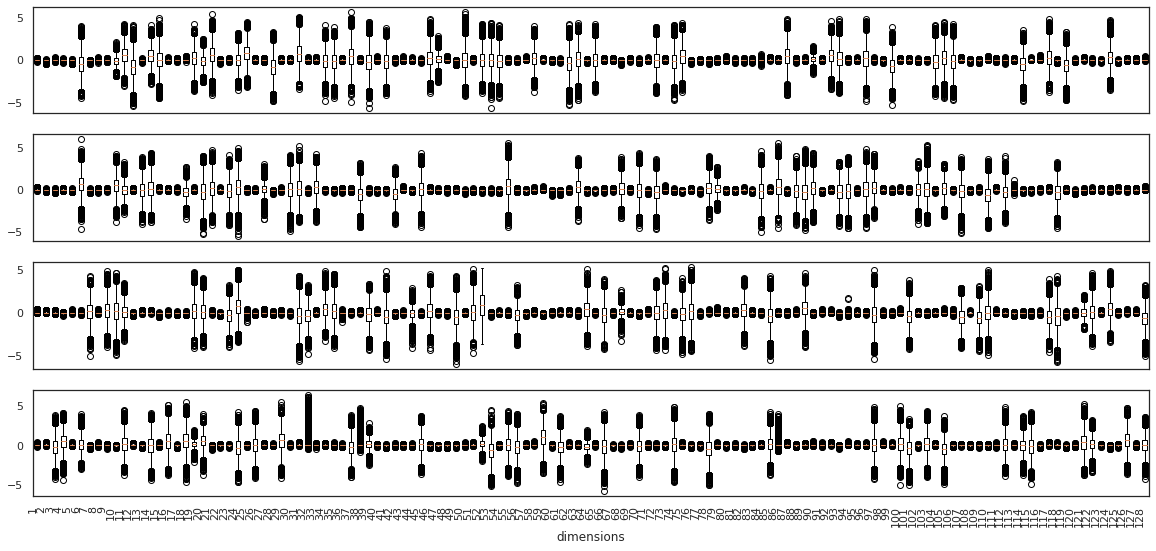

In [18]:
# 繪製512維的特徵分布圖
fig, axs = plt.subplots(4,1,figsize=(20,10))

for i in range(4):
    axs[i].boxplot(features[:,i*128:(i+1)*128])
#     axs[i].set_xlabel( [t for t in range(i*128,(i+1)*128)])
plt.xlabel('dimensions')

fig.autofmt_xdate(rotation=90)
# fig.savefig(f"./results/latent/features_boxplot_ck{ck}.png", bbox_inches='tight')

In [ ]:
for i in range(4):
    axs[i].boxplot(features[:,i*128:(i+1)*128])
#     axs[i].set_xticks([i for i in range(i*128,(i+1)*128)])
plt.xlabel('dimensions')
# plt.title('B')
fig.autofmt_xdate(rotation=90)

In [ ]:
# 檢視512維特徵值的分布
# for v in range(512):
#     f = features[:,v]
#     print(f'v:{v:3d},  min:{f.min():.3f},  max:{f.max():.3f}, mean:{f.mean():.3f}, std:{f.std():.3f}')

#### 將latent space 內的512個特徵值內插作圖

In [ ]:
n=16
model.to('cpu')
for f in range(512):
    zero = torch.zeros((1,512))
    # 產出該維度特徵內插值
    fea = features[:,f]
    dis = 1.1*(fea.max()-fea.min())/2  # 計算該維度的值分布範圍
    linspace = torch.tensor(np.concatenate((np.linspace(-dis, 0, n), np.linspace(0, dis, n))))
#     linspace = torch.tensor(np.linspace(-5,5, n))
    dimension_list = []
    for l in linspace:
        zero[0][f] = l
        dimension_list.append(zero.clone())
        
    # 將該維度內插值送入decoder產生ㄟ圖像
    x_hat_list = []
    for d in range(len(dimension_list)):
        with torch.no_grad():
            x_hat = model.decoder(dimension_list[d]) 
            x_hat_list.extend(x_hat)
    im_convert(torchvision.utils.make_grid(x_hat_list, nrow=8, padding=2), f_name=f'Dimensions_{f}' , save=True)
#     if f==0:break

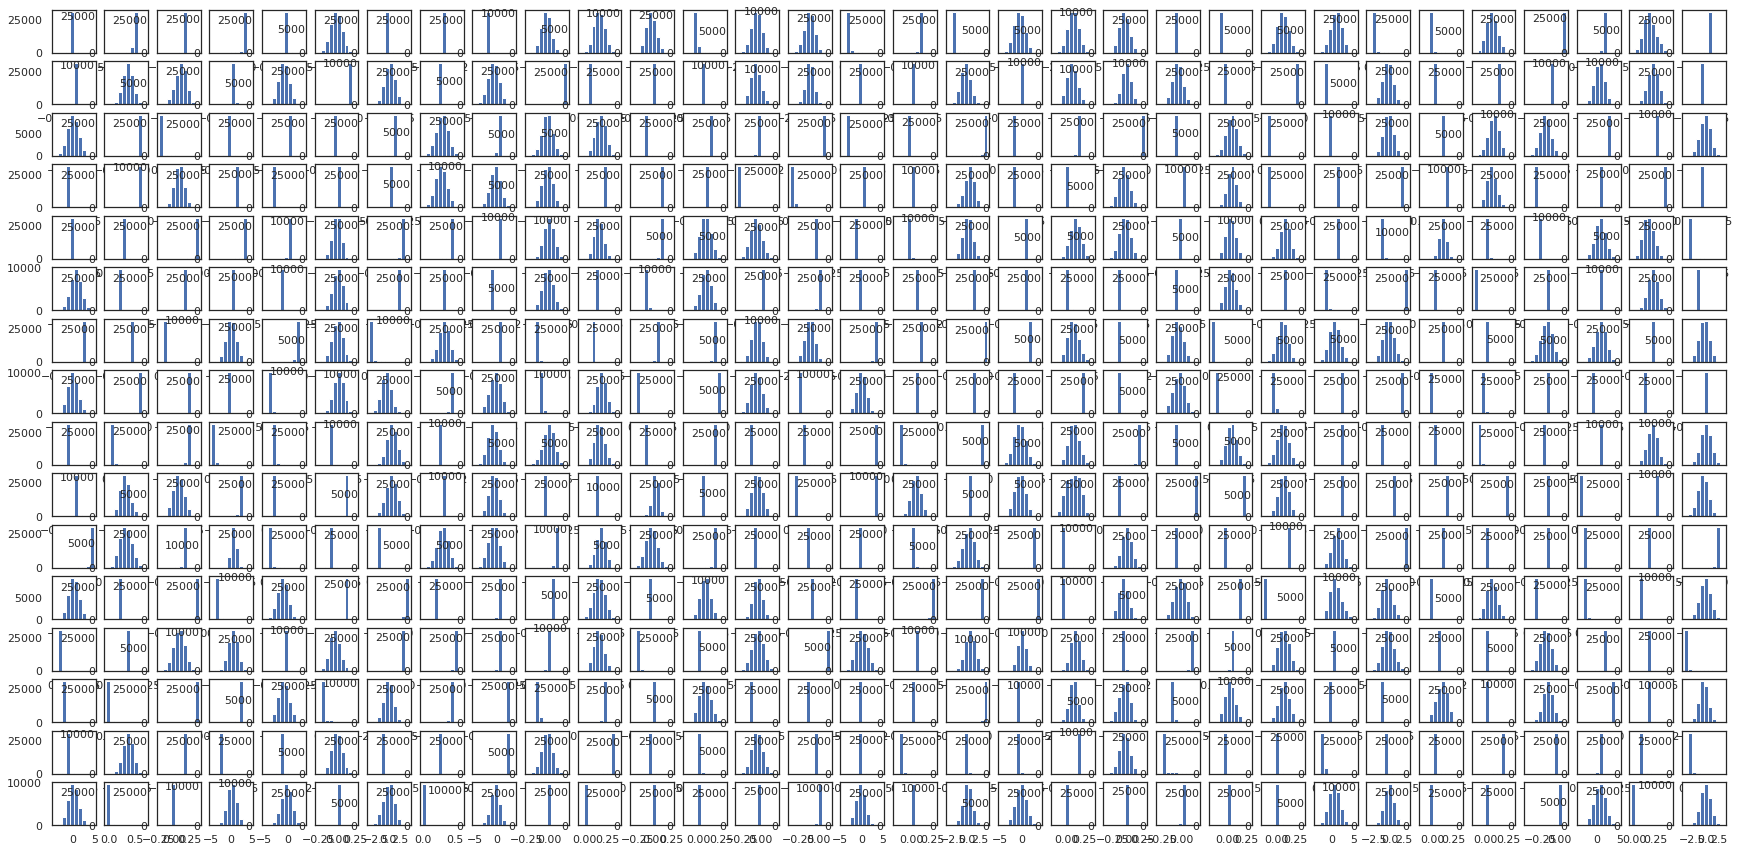

In [72]:
fig, ax_array = plt.subplots(16, 32, figsize=(30,15))
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.hist(features[:,i], bins=10)
plt.savefig(f"./results/latent/Features_hist.png", bbox_inches='tight')

#### 繪圖檢視各科物種特徵的平均值

In [6]:
moth_meta = pd.read_csv(f'./meta/moth_meta_20210610.csv')
moth_meta 

,Family,Subfamily,Genus,Species,SciName,Number,Source,Family_encode,Fam_Sample,Fam_Specie
0,Notodontidae,Phalerinae,Datana,perspicua,Datana perspicua,2432375495,CSU,60,741,530
1,Geometridae,Ennominae,Borbacha,pardaria,Borbacha pardaria,A37-20180907-057,TESRI,34,4684,3138
2,Geometridae,Ennominae,Cleora,fraterna,Cleora fraterna,A34-20130506-024,TESRI,34,4684,3138
3,Tortricidae,Olethreutinae,Olethreutes,osmundana,Olethreutes osmundana,1838875462,MISSA,84,938,802
4,Geometridae,Geometrinae,Hemistola,monotona,Hemistola monotona,A52-20160704-154,TESRI,34,4684,3138
...,...,...,...,...,...,...,...,...,...,...
32257,Tineidae,Tineinae,Tinea,occidentella,Tinea occidentella,2432338673,CSU,82,102,85
32258,Geometridae,Geometrinae,Episothalma,robustaria,Episothalma robustaria,1826442741,NHMUK,34,4684,3138
32259,Oecophoridae,Depressariinae,Eupragia,hospita,Eupragia hospita,1585226502,MISSA,62,70,65
32260,Nymphalidae,Limenitidinae,Neptis,hylas,Neptis hylas,1039028551,YPM,61,3999,1655


In [7]:
# 建立科名encoing的字典對照表  
Fam_dic = dict(zip(range(97),
                   moth_meta.Family.sort_values().unique()))        # 取得科名按字母排序

In [60]:
for i,(_,v) in enumerate(Fam_dic.items()):  # k:Family_encode, v:Family
    # 取得各科特徵值的平均
    mask = moth_meta.Family.isin([v])  # 等同於 f_meta.Family==k
    index = moth_meta[mask].index
    f_mean = torch.tensor(features[index,:].mean(axis=0)).reshape((-1,512))  # (512,) >　torch.Size([(1, 512)])
    if i==0:
        features_mean = f_mean
    else:
        features_mean = torch.cat((features_mean, f_mean), dim=0)
print(f'feature_shape: {features_mean.shape}')  # torch.Size([(97, 512)])

# 將取均值的特徵送入decoer產生重建的影像
with torch.no_grad():
    rec = model.decoder(features_mean)  # torch.Size([97, 3, 256, 256])

In [ ]:
# 繪圖-將97科蛾類繪製在一張圖上
fig, axes = plt.subplots(7,14, figsize=(32,18))
for i, ax in enumerate(axes.flat):
    ax.set_yticks([]); ax.set_xticks([]); ax.axis('off') # 隱藏邊框及刻度 
    if i < len(rec) :                                    # 蛾類有97科
        image = (rec[i].numpy()
                 .transpose(1, 2, 0) # (c,w,h) > (w,h,c)
                 .clip(0, 1))         
        ax.imshow(image)
        get_Family = f_meta[f_meta.Family_encode == i]   # 取得科名
        sp =  get_Family.Fam_Specie.unique()[0]          # 各科物種數
        n =   get_Family.Fam_Sample.unique()[0]          # 各科樣本數
        ax.set_title(f'{Fam_dic[i]}\n sp:{sp}, n:{n}',
                     {'fontsize': 12} )
plt.savefig(f'./results/family_Feature_Mean/Mean_All_Nbelow10.png', bbox_inches='tight');

In [ ]:
# 繪圖-將97科蛾類各自繪圖
for i,(_,v) in enumerate(Fam_dic.items()):  
    image = (rec[i].numpy()
             .transpose(1, 2, 0) # (c,w,h) > (w,h,c)
             .clip(0, 1))    
    plt.title(f'{v}_Mean', {'fontsize': 16} )
    plt.imshow(image)
    plt.savefig(f'./results/family_Feature_Mean/Mean_{v}.png', bbox_inches='tight')
    print(f'Mean_{v}.png saved! \t\t', end='\r');

### 2. 降維探索
#### 2.1. 將編碼後的 features 用 UMAP 降維
- UMAP 工具參見 https://pypi.org/project/umap-learn/
- 如果跑不動 3 萬餘張照片，可先對每個種求平均後再降到 2 or 3 維。  
  @YYChen 用的 AS-GPU 上之前應該有裝好了。  
  @YungHuiHsu 如果裝不起來(會有一大堆軟體版本衝突)，超過一小時依然無法解決，請找 @GSMai 。

#### 2.2. 畫降維後的 scatter plot
- 依科上色，現階段應該已經可以看出特徵有照科群聚的特性了。
  - 如果因為科數量太多而看不清楚，可先挑選前 20 或前 50 大科試試。
  - 科的大小以科內物種數決定。

#### 2.3. 找出最佳的 n_neighbors 參數 
- UMAP n_neighbors 的 default==15
- 可嘗試如 50, 100 or 200，並以分群評估指標如 Silhouettes, Calinski Harabaszs, Davies Bouldins 來尋找最適 hyper-parameters。  
  - 前兩者愈大愈好，後者愈小愈好，細節請先參照 sklearn 官方文件。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# %matplotlib widget
sns.set(style='white', context='notebook', rc={'figure.figsize':(16,12)})

In [8]:
import umap

In [9]:
ck = 4300
features = np.load(f'./meta/features_ck{ck}.npy')
features.shape

(32262, 512)

In [10]:
moth_meta = pd.read_csv(f'./meta/moth_meta_20210610.csv')
moth_meta 

,Family,Subfamily,Genus,Species,SciName,Number,Source,Family_encode,Fam_Sample,Fam_Specie
0,Notodontidae,Phalerinae,Datana,perspicua,Datana perspicua,2432375495,CSU,60,741,530
1,Geometridae,Ennominae,Borbacha,pardaria,Borbacha pardaria,A37-20180907-057,TESRI,34,4684,3138
2,Geometridae,Ennominae,Cleora,fraterna,Cleora fraterna,A34-20130506-024,TESRI,34,4684,3138
3,Tortricidae,Olethreutinae,Olethreutes,osmundana,Olethreutes osmundana,1838875462,MISSA,84,938,802
4,Geometridae,Geometrinae,Hemistola,monotona,Hemistola monotona,A52-20160704-154,TESRI,34,4684,3138
...,...,...,...,...,...,...,...,...,...,...
32257,Tineidae,Tineinae,Tinea,occidentella,Tinea occidentella,2432338673,CSU,82,102,85
32258,Geometridae,Geometrinae,Episothalma,robustaria,Episothalma robustaria,1826442741,NHMUK,34,4684,3138
32259,Oecophoridae,Depressariinae,Eupragia,hospita,Eupragia hospita,1585226502,MISSA,62,70,65
32260,Nymphalidae,Limenitidinae,Neptis,hylas,Neptis hylas,1039028551,YPM,61,3999,1655


### 選取前20、50大科作圖
- 依樣本數量
- 依物種數量

1. 計算各科樣本、物種數量，新增欄位保留計算結果
2. 抓取想要的科所對應的INDEX位置
3. 匯圖時直接抓取對應的INDEX

In [221]:
# 按樣本數、物種數排序最多的科
n=15
pd.concat([moth_meta.groupby(['Family']).SciName.nunique().sort_values()[::-1][:n],  # 物種數
           moth_meta.groupby(['Family']).DataID.nunique().sort_values()[::-1][:n]],  # 樣本數
          axis=1)

,SciName,DataID
Geometridae,3198,4795
Erebidae,2667,5090
Noctuidae,2218,3747
Nymphalidae,1666,4037
Pieridae,852,3076
Tortricidae,787,901
Lycaenidae,708,1492
Crambidae,693,1196
Hesperiidae,589,1449
Notodontidae,528,739


In [211]:
# 檢視各科案樣本數量取樣的分布狀態
fam_Sample = moth_meta.Fam_Sample.unique()
number_list=[10,50,100,500,1000] 

print('Samples per Family :', end='\t')
for n in number_list:
    print(f'{n:2d}:{np.sum(fam_Sample > n):2d}.', end=' '*4)
# pd.DataFrame(fam_Sample).plot(kind='hist',bins=100, figsize=(6,3), title='Samples per Family' );

# 檢視各科按物種數量取樣的分布狀態

fam_Specie = moth_meta.Fam_Specie.unique()
print('\nSpecies per Family :', end='\t')
for n in number_list:
    print(f'{n:2d}:{np.sum(fam_Specie > n):2d}.', end=' '*4)
# pd.DataFrame(fam_Specie).plot(kind='hist',bins=100, figsize=(6,3), title='Species per Family' );

Samples per Family :	10:45.    50:29.    100:20.    500:14.    1000: 9.    
Species per Family :	10:42.    50:26.    100:16.    500:10.    1000: 4.    

##### 計算各科物種數、樣本數

### 分群評估指標  
- Silhouettes(輪廓係數)
  - 介於-1 ~ 1，越接近-1表示樣本越應該被分類至其他群集。越大越好
  - $ \frac{b-a}{max(a,b)}$
    - a: 該點與同群集內，其他樣本的平均距離
    - b: 該點與最近相鄰群集內，其他樣本的平均距離 
- Calinski Harabaszs(Variance Ratio Criterion)
  - 所有群集的 群間分散度/群內分散度 加總(分散度定義採用距離均方)
  - 越大代表群間越分離、群內越聚集
- Davies Bouldins
  - 聚類之間的平均 "相似度": 將群之間的距離與群本身的大小進行比較
  - 越接近0代表樣本分配越好
  - $\frac{s_i + s_j}{d_ij}$   
    - s: 群內每個點與該群中心點的平均距離(群的直徑)
    - d: 群中心點i和j之間的距離。


In [12]:
n_neighbors = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500]

In [ ]:
def get_embedding(n_components=2, n_neighbors=n_neighbors, metric='euclidean'):
    for n in n_neighbors:
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n, verbose=True, metric=metric)
        embedding = reducer.fit_transform(features)
        root = f'./meta/embedding_{n_components}D_{metric}_{n}.npy'
        np.save(root, embedding)
        print(f'{root} saved', end='\r') 
    print(f'Finished') 

# get_embedding(n_components=2, n_neighbors=n_neighbors)
# get_embedding(n_components=3, n_neighbors=n_neighbors)
# get_embedding(n_components=2, n_neighbors=n_neighbors, metric='cosine')
# get_embedding(n_components=3, n_neighbors=n_neighbors, metric='cosine')

In [32]:
def metric_silhouette_score(n_neighbors=n_neighbors, Dim='2D'):
    silhouette_score=[]
    for n in n_neighbors:
        embedding = np.load(f'./meta/embedding_{Dim}_{n}.npy')
        score = metrics.silhouette_score(embedding, f_meta.Family, metric='euclidean')
        silhouette_score.append(score)
        print(f'n_neighbors: {n:3d}, score: {score:.3f} ', end='\r')
    return silhouette_score
# silhouette_score_2D = metric_silhouette_score(n_neighbors=n_neighbors, Dim='2D_euclidean')
# silhouette_score_3D = metric_silhouette_score(n_neighbors=n_neighbors, Dim='3D_euclidean')
# silhouette_score_2D_Cos = metric_silhouette_score(n_neighbors=n_neighbors, Dim='2D_cosine')
# silhouette_score_3D_Cos = metric_silhouette_score(n_neighbors=n_neighbors, Dim='3D_cosine')

# columns = pd.MultiIndex.from_product([['SilHouette'], ['2D', '3D','2D_Cos','3D_Cos']], names=['Score_metrc', 'Diemension'])
# silhouette_score = pd.DataFrame({'2D':silhouette_score_2D,  '3D':silhouette_score_3D,'2D_Cos':silhouette_score_2D_Cos, '3D_Cos':silhouette_score_3D_Cos}, index=n_neighbors)
# silhouette_score.columns= columns
# silhouette_score.to_csv('./meta/silhouette_score.csv')

In [13]:
def metric_cal_har_score(n_neighbors=n_neighbors, Dim='2D'):
    cal_har_score=[]
    for n in n_neighbors:
        embedding = np.load(f'./meta/embedding_{Dim}_{n}.npy')
        score = metrics.calinski_harabasz_score(embedding, f_meta.Family)
        cal_har_score.append(score)
        print(f'n_neighbors: {n:3d}, score: {score:.3f} ', end='\r')
    return cal_har_score

cal_har_score_2D = metric_cal_har_score(n_neighbors=n_neighbors, Dim='2D_euclidean')
cal_har_score_3D = metric_cal_har_score(n_neighbors=n_neighbors, Dim='3D_euclidean')
cal_har_score_2D_Cos = metric_cal_har_score(n_neighbors=n_neighbors, Dim='2D_cosine')
cal_har_score_3D_Cos = metric_cal_har_score(n_neighbors=n_neighbors, Dim='3D_cosine')

columns = pd.MultiIndex.from_product([['Calinski_Harabasz'], ['2D', '3D','2D_Cos','3D_Cos']], names=['Score_metrc', 'Diemension'])
cal_har_score = pd.DataFrame({'2D':cal_har_score_2D,  '3D':cal_har_score_3D,'2D_Cos':cal_har_score_2D_Cos, '3D_Cos':cal_har_score_3D_Cos}, index=n_neighbors)
cal_har_score.columns= columns

In [14]:
def metric_dav_bou_score(n_neighbors=n_neighbors, Dim='2D'):
    dav_bou_score=[]
    for n in n_neighbors:
        embedding = np.load(f'./meta/embedding_{Dim}_{n}.npy')
        score = metrics.davies_bouldin_score(embedding, f_meta.Family)
        dav_bou_score.append(score)
        print(f'n_neighbors: {n:3d}, score: {score:.3f} ', end='\r')
    return dav_bou_score
dav_bou_score_2D = metric_dav_bou_score(n_neighbors=n_neighbors, Dim='2D_euclidean')
dav_bou_score_3D = metric_dav_bou_score(n_neighbors=n_neighbors, Dim='3D_euclidean')
dav_bou_score_2D_Cos = metric_dav_bou_score(n_neighbors=n_neighbors, Dim='2D_cosine')
dav_bou_score_3D_Cos = metric_dav_bou_score(n_neighbors=n_neighbors, Dim='3D_cosine')
columns = pd.MultiIndex.from_product([['Davies_Bouldin'], ['2D', '3D','2D_Cos','3D_Cos']], names=['Score_metrc', 'Diemension'])
dav_bou_score = pd.DataFrame({'2D':dav_bou_score_2D,  '3D':dav_bou_score_3D,'2D_Cos':dav_bou_score_2D_Cos, '3D_Cos':dav_bou_score_3D_Cos}, index=n_neighbors)
dav_bou_score.columns = columns

In [15]:
silhou_score = pd.read_csv('./meta/silhouette_score.csv', index_col=0, header=[0, 1])
(pd.concat([silhou_score, cal_har_score, dav_bou_score],axis=1)
 .to_csv('./meta/Metric_score_nNeighbors.csv'))
metric_score = pd.read_csv('./meta/Metric_score_nNeighbors.csv', index_col=0, header=[0, 1])
metric_score 

Score_metrc SilHouette                               Calinski_Harabasz  \
Diemension          2D        3D    2D_Cos    3D_Cos                2D   
5            -0.430266 -0.302652 -0.259665 -0.234774        251.888839   
10           -0.240010 -0.325987 -0.366329 -0.308956       1095.111726   
15           -0.269892 -0.215099 -0.346058 -0.313212       1246.716287   
20           -0.288427 -0.235904 -0.309959 -0.287336       1427.503551   
30           -0.262480 -0.251298 -0.285947 -0.275298       1587.210827   
40           -0.253357 -0.229696 -0.290339 -0.211458       1789.496572   
50           -0.268619 -0.224733 -0.271800 -0.217899       1796.464997   
60           -0.272935 -0.218542 -0.270042 -0.209808       1997.688746   
70           -0.266591 -0.218334 -0.270602 -0.205458       1958.924174   
80           -0.263236 -0.214864 -0.260677 -0.205226       1962.596342   
90           -0.263979 -0.208853 -0.263149 -0.203629       2091.647430   
100          -0.274050 -0.216215 -0.258716 -0.209421       2050.305005   
200          -0.259605 -0.204906 -0.253067 -0.189113       2202.475713   
300          -0.242835 -0.191601 -0.245122 -0.184250       2267.093966   
500          -0.249093 -0.185585 -0.241142 -0.183253       2427.937418   

Score_metrc                                        Davies_Bouldin            \
Diemension            3D       2D_Cos       3D_Cos             2D        3D   
5             866.095024   681.290740   842.822541      14.353915  7.035438   
10           1085.748461  1108.417713   957.297718      15.221362  8.242928   
15           1246.382217  1262.782833  1206.753513      14.360326  9.564823   
20           1331.843882  1402.426517  1427.834871      16.673333  7.809666   
30           1489.882275  1509.916652  1633.084741      12.201724  8.021387   
40           1664.759703  1575.531327  1841.543456      13.425605  9.230457   
50           1924.190272  1966.335725  2032.553157      14.248947  9.048207   
60           2074.780556  2129.080214  2148.524345      10.757349  8.485153   
70           2132.754928  1957.867082  2200.670647      12.599101  9.417708   
80           2112.809244  2039.603526  2287.665253      11.398685  8.459412   
90           2156.411212  2005.194514  2347.851101      10.949698  8.467614   
100          2200.430151  1999.350926  2358.328572      15.327371  6.774493   
200          2502.523961  2331.842438  2492.052857      13.203304  7.576864   
300          2618.630806  2262.627348  2588.523254      13.591885  7.086066   
500          2514.120168  2325.741208  2567.474632      14.943275  6.318614   

Score_metrc                        
Diemension      2D_Cos     3D_Cos  
5            22.735328   6.753704  
10           18.582902   8.326937  
15           12.755907   8.346571  
20           13.438321   9.342801  
30           10.106237   9.637449  
40           19.507126  10.902409  
50           12.208169   9.372955  
60            9.598481   8.607269  
70           11.350053  14.604389  
80           13.941972   8.726265  
90           17.602460   8.238988  
100          14.218842   8.053709  
200          11.889002   7.000830  
300          13.084972   6.721143  
500          13.827825   6.375594

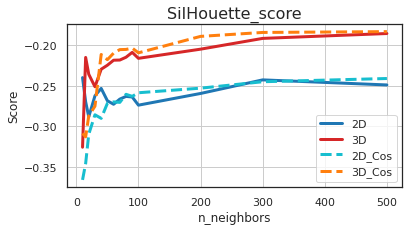

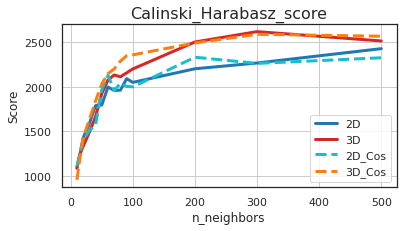

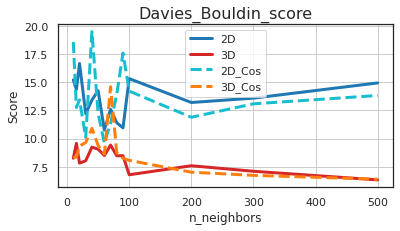

In [217]:
def metric_plot(s=0,e=15,metric='SilHouette'):  # SilHouette, Calinski_Harabasz	, Davies_Bouldin
    metric_score = pd.read_csv('./meta/Metric_score_nNeighbors.csv', index_col=0, header=[0, 1])
    plt.figure(figsize=(6,3))
    metric_score[s:e][metric]['2D'].plot(style='-',lw=3, c='tab:blue')
    metric_score[s:e][metric]['3D'].plot(style='-',lw=3, c='tab:red')
    metric_score[s:e][metric]['2D_Cos'].plot(style='--',lw=3, c='tab:cyan')
    metric_score[s:e][metric]['3D_Cos'].plot(style='--',lw=3, c='tab:orange')
    plt.grid()
    plt.ylabel('Score')
    plt.xlabel('n_neighbors')
    plt.legend()
    plt.title(f'{metric}_score',fontsize=16)
    plt.savefig(f"./results/latent/{metric}_score.png", bbox_inches='tight');

for m in['SilHouette', 'Calinski_Harabasz', 'Davies_Bouldin']:
    metric_plot(s=1, metric=m)
#     metric_plot(s=1,e=7, metric=m)
    

#### 分群指標評估- n_neighbors：  
- n_neighbors在小於50內較不穩定
- metric採用 cosine與euclidean 沒有明顯一致的差異
  - VSC處理得到的latent space 會以0為中心($u=0$)，呈slab+spike分布 
- 各指標
  - Silhouettes在200-500間到曲線高原位置
  - Calinski Harabaszs在200-500間到曲線高原位置(越大越好，分子為群間距離變異、分母為群內距離)
  - Davies Bouldins低點在100-500間
  - 三種指標綜合考量，選取200或300較合適

### 2D作圖

In [141]:
def cluster_2Dplot(n_neighbors=200, metric='euclidean',sample=500, save=None):
    plt.close()
    print(f'Umap_2D_{metric}_sample{sample}_neighbor{n_neighbors}')
    index = f_meta[f_meta.Fam_Sample > sample].index  #指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    embedding_ = pd.DataFrame(np.load(f'./meta/embedding_2D_{metric}_{n_neighbors}.npy'))
    meta_ = f_meta[['Family','Family_encode']]             # 取得科的標籤 
    embedding = pd.concat( [embedding_ , meta_], axis=1)    
    scatter = plt.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1],
                c=embedding.iloc[index, 3],
                lw=.05, s=9, edgecolors='black',
                cmap='Spectral')
    # 取出legen元素，圖標 handles與 標籤labels
    handles, labels = scatter.legend_elements(num=embedding.iloc[index,2].nunique())
    family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字

    plt.legend(          
#     *scatter.legend_elements(),
        handles=handles, labels=family_list,
        title='Family', ncol=4, markerscale=1)

    plt.title(f'UMAP_Moth', fontsize=24)
    plt.suptitle(f'n_neighbors:{n_neighbors},\n metric:{metric}, sample>{sample} ',
                 x=0.75, y=0.91, fontsize=12, fontweight='light')
    plt.gca().set_aspect('equal', 'datalim')
    
    if save==True:
        plt.savefig(f"./results/umap/Umap_2D_{metric}_sample{sample}_neighbor{n_neighbors}.png", bbox_inches='tight')
    ;

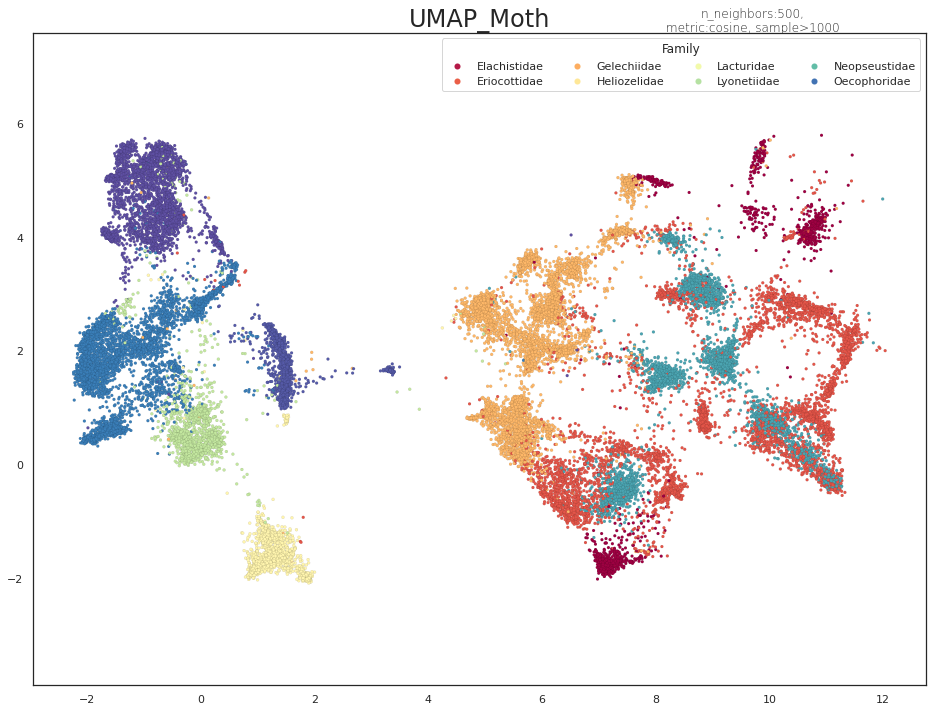

In [142]:

n_neighbors = [15, 50, 100, 200, 300, 500]
sample_list= [100, 500, 1000]

for s in sample_list:
    index = moth_meta[f_meta.Fam_Sample>s].index  #指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    for n in n_neighbors:
        cluster_2Dplot(n_neighbors=n,  metric='euclidean', sample=s, index=index, save=True)
        cluster_2Dplot(n_neighbors=n,  metric='cosine'   , sample=s, index=index, save=True)

#### 單色作圖
1. 疊兩個圖層
  1. 指定欲上色的科別(編碼)-圖層1
  2. 其他則用灰階-圖層2
2. 選出指定的科名(編碼)
  - 將其他沒有選擇的編碼指定為-99，並將顏色指定為灰色

In [17]:
def cluster_2DplotByS(n_neighbors=200, metric='euclidean', sample=500, save=None):    
    
    # 取得基本資料
    index = moth_meta[f_meta.Fam_Sample > sample].index                    # 指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    embedding_ = pd.DataFrame(np.load(f'./meta/embedding_2D_{metric}_{n_neighbors}.npy'))
    meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
    embedding = pd.concat( [embedding_ , meta_], axis=1)
    sample_list = embedding.iloc[index,:].Family.sort_values().unique() # 從已篩選過樣本數量的embedding中建立類別(科)清單
    print('Samole Number:', len(sample_list), sample_list)
    
    for i, f in enumerate(sample_list):
        print(f'Ploting {f} ...')
        plt.close()                                                     # 清空前一張圖避免重疊繪圖，以及釋放記憶體空間
        fig = plt.figure(figsize=(16,9),clear=True)
        ax = plt.subplot()
        indexByS = moth_meta[f_meta.Family == f].index                     # 取得單一物種的index位置 
        
        ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1],  # 建立所有類別的scatter底圖
                    c='lightgrey', lw=.1, s=3)

        # 建立單一欲顯色的類別scatter圖
        scatter = ax.scatter(embedding.iloc[indexByS, 0], embedding.iloc[indexByS, 1],
                             c=embedding.iloc[indexByS, 3],
                             lw=.1, s=9, edgecolors='b', cmap='Spectral')
        
        # 取出legen元素，圖標 handles與 標籤labels
        handles, labels = scatter.legend_elements()  # labels
        family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
        ax.legend(
        #     *scatter.legend_elements(),
            handles=handles, labels=family_list,
            title='Family', ncol=4, markerscale=1)

        plt.title(f'UMAP_Moth - {f}', fontsize=24)
        plt.suptitle(f'n_neighbors:{n_neighbors},\n sample>{sample} ', x=0.75, y=0.92, fontsize=12, fontweight='light')
        plt.gca().set_aspect('equal', 'datalim');
        if save==True:
            plt.savefig(f"./results/umap/Umap_2D_sample{sample}_neighbor{n_neighbors}_{f}.png", bbox_inches='tight')
        

In [ ]:
cluster_2DplotByS(sample=100, save=True)

In [8]:
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,12)})

In [9]:
sns.__version__

'0.10.1'

### 3D作圖

In [6]:
def cluster_3Dplot(n_neighbors=200, metric='euclidean', sample=500, save=None):    
    index = moth_meta[f_meta.Fam_Sample > sample].index  #指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    embedding_ = pd.DataFrame(np.load(f'./meta/embedding_3D_{metric}_{n_neighbors}.npy'))
    meta_ = moth_meta[['Family','Family_encode']]             # 取得科的標籤 
    embedding = pd.concat( [embedding_ , meta_], axis=1)    
    
    plt.close()   
    fig = plt.figure()
    ax = Axes3D(fig)
    scatter = ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1], embedding.iloc[index, 2],
                         c=embedding.iloc[index, 4],
                         cmap='Spectral', lw=.05, s=9, edgecolors='black')
    # 取出legen元素，圖標 handles與 標籤labels
    handles, labels = scatter.legend_elements(num=embedding.iloc[index,3].nunique())
    family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
    
    ax.legend(
#     *scatter.legend_elements(),
        handles=handles, labels=family_list,
        title='Family', ncol=4, markerscale=1)

    plt.title(f'UMAP_Moth', fontsize=24, loc='left')
    plt.suptitle(f'n_neighbors:{n_neighbors},\n sample>{sample} ', x=0.1, y=0.97, fontsize=12, fontweight='light')
    
    if save==True:
        plt.savefig(f"./results/umap/Umap_3D_sample{sample}_neighbor{n_neighbors}.png", bbox_inches='tight')
#     ;

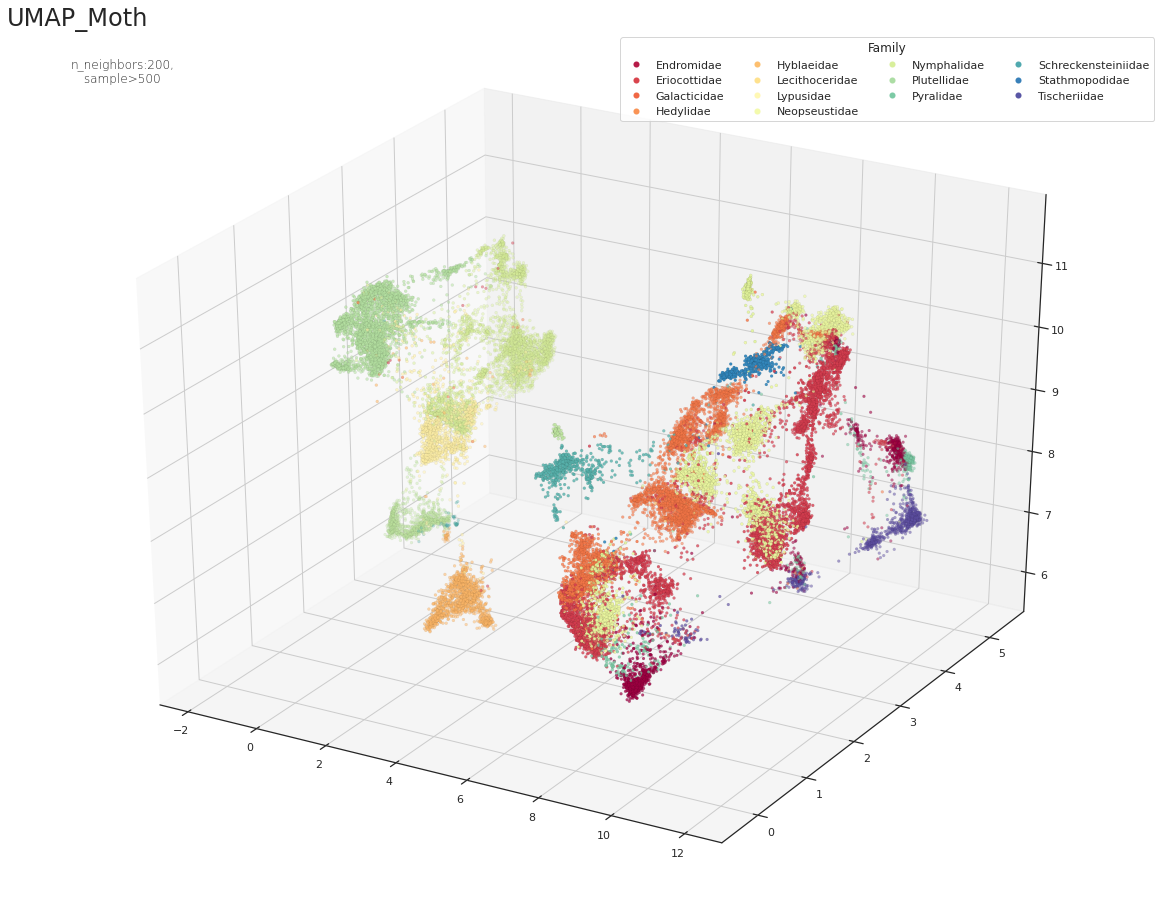

In [7]:
cluster_3Dplot(n_neighbors=200, save=False)

Task :
1. 3D繪圖檢視
2. 2D繪圖-製作出單一有色彩、其他灰階